In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import celllist as cl
import verlet as vl
import pse
import particles as p

There QS model comprises three components:
1. Diffusion and exponential decay of signaling molecules outside bacteria (Diffusion)
2. An ODE model for the production of molecules inside bacteria (Reaction)
3. Handling of the influx and outflix of molecules across the cell membrane (Advection)

*Not resolving the spatial extension of a bacterium*

Implement the source term of the ODE inside a cell, $f$, find the formula on the JMB paper:

$f(x_c) := \alpha + \frac{\beta x^n_c}{x^n_\text{thresh} + x^n_c} - \gamma_cx_c$

where
- $\alpha$ is the low production rate of AHL
- $\beta$ is the increase of production rate of AHL
- $x_c$ is the mass of AHL within the cytoplasm
- $x_e$ is the mass of AHL outside the cell
- $\gamma_c$ is the degradation rate of AHL in the cytosol

The second sum term in the r.h.s. can be expressed in terms of concentrations, too (volumes are dividing on both sides) 

In [2]:
def fQS(u_c: np.ndarray,
        alpha: float, beta:
        float, u_thresh: float,
        n: int, gamma: float) -> np.ndarray:
    """
    u_c: np.ndarray with shape (numParticles, 1)
    output: np.ndarray with shape (numParticles, 1)
    """
    # We are not considering the last term gamma_c*u_c
    return alpha + (beta*u_c**n)/(u_thresh**n + u_c**n) - gamma*u_c

In [3]:
alpha = 1
beta = 100
u_thresh = 2
n = 10
u_c = np.linspace(0, 10, 100)

f = fQS(u_c, alpha, beta, u_thresh, n, 0.5)

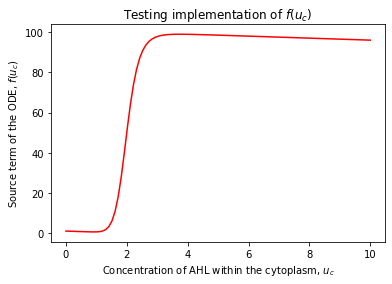

In [4]:
plt.plot(u_c, f, color="red")
plt.xlabel(r"Concentration of AHL within the cytoplasm, $u_c$")
plt.ylabel(r"Source term of the ODE, $f(u_c)$")
plt.title(r"Testing implementation of $f(u_c)$")
plt.show()

In [5]:
def applyQS(u_e: np.ndarray, 
            u_c: np.ndarray, 
            QScellIndex: np.ndarray,
            d_1: float, d_2:float,
            gamma_e: float,
            **kwargs) -> (np.ndarray, np.ndarray):

    _u_c = np.zeros(len(u_e))
    _u_c[QScellIndex] = u_c[QScellIndex]
    
    _u_e = np.zeros(len(u_e))
    _u_e[QScellIndex] = u_e[QScellIndex]
    
    fQS_filter = np.zeros(len(u_e))
    fQS_filter[QScellIndex] = fQS(_u_c, **kwargs)[QScellIndex]
    
    du_c = fQS_filter + d_1*_u_e - d_2*_u_c
    du_e = -d_1*_u_e + d_2*_u_c - gamma_e*u_e
    return du_e, du_c

### Part 2: Couple the QS reaction with Diffusion, random grid

In [6]:
def interactiveAdvectionDiffusionReaction(T, N, particleMat,
                                          verletList, epsilon,
                                          dim, QScellIndex,
                                          d_1, d_2, gamma_e,
                                          alpha, beta, u_thresh,
                                          n, gamma, h, cutoff, numStren):
    t = 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()

    fig.canvas.draw()

    X = particleMat[:,0].reshape((N, N))
    Y = particleMat[:,1].reshape((N, N))

    while t < T:
        # Run the PSE
        pseSum = pse.applyPSE(particleMat,verletList,epsilon,1,dim)

        # Apply the QS to all particles
        br = applyQS(particleMat[:,dim+1], 
                     particleMat[:,dim+2], 
                     QScellIndex,
                     d_1, d_2,
                     gamma_e = gamma_e,
                     alpha = alpha,
                     beta = beta,
                     u_thresh = u_thresh,
                     n = n, gamma = gamma)

        # Apply for all strengths
        particleMat[:,(dim+1)] = particleMat[:,(dim+1)] + (pseSum[:,0]*V*D/(epsilon**2) + br[0])*dt
        particleMat[:,(dim+2)] = particleMat[:,(dim+2)] + br[1]*dt

        # Apply periodic boundary conditions
        tempMat = particleMat[:,(dim+1):].reshape((N,N,-1))
        tempMat = pse.periodicBoundaries(tempMat,h,cutoff,bW,N,N)
        particleMat[:,(dim+1):] = tempMat.reshape((numParticles, numStren))

        # Concentration across space plot
        U=particleMat[:,dim+1].reshape((N, N))
        ax.clear()
        ax.pcolormesh(X,Y,U, cmap = "viridis")
        ax.set_title("t = {:0.2f}s, $\sum u_e = {:0.2f}$, $\sum u_c = {:0.2f}$".format(t, np.sum(particleMat[:,dim+1]), np.sum(particleMat[:,dim+2])))
        fig.canvas.draw()
        plt.pause(0.001)

        # Update the time step
        t += dt

In [7]:
d_1 = 0.25
d_2 = 2.5

In [8]:
"""
Global parameters of the simulation
"""

# Number of particles per dimension
N = 51
# Bounds of the grid
lBounds, uBounds = 0, 50
# Dimensions of the grid, and type
dim, kind = 2, 1
# Total number of particles
numParticles = N**dim
# Grid spacing
h = (uBounds-lBounds)/(N - 1)
# Mollification width
epsilon = h
# Paramters for the cell list
cutoff = 3*epsilon
cellSide = cutoff
numStren = 2

# Diffusion constant
D = 1
# Maximum time of the simulation
T = 20
# Time step
dt = h**2/(4*D)
# All particles have same volume,
# corresponds to the cell width
V = h**2

# For the periodic boundary conditions
bW = np.round(cutoff/h)

In [9]:
# Initial time to 0
t = 0

particlePos = p.createParticles(numParticles,dim,lBounds,uBounds,kind)
# We will store u_c and u_e (2 properties), initialized all to zero
particleStrength = np.zeros((numParticles, 2))

particleMat,cellList,numCells = cl.createCellList(particlePos,lBounds,uBounds,cellSide)
verletList = vl.createVerletList(particleMat,cellList,numCells,cutoff)

particleMat = np.hstack((particleMat, particleStrength))

In [10]:
# Bacteria center of the grid
idx_center = np.ravel_multi_index(np.array([26, 0]), (50, 50))
# Save as an index
QScellIndex = np.array([idx_center])
# Initialize the u_c for that cell as u_thresh
# knowing that particleMat is [x, y, cell, u_e, u_c]
particleMat[idx_center, dim+2] = u_thresh

# Set the gamma
gamma = 0.5
gamma_e = 0.5

In [11]:
%matplotlib qt5
plt.rcParams["figure.figsize"] = (5, 5)

In [12]:
interactiveAdvectionDiffusionReaction(T, N, 
                                      particleMat, verletList, epsilon,
                                      dim, QScellIndex, d_1, d_2, gamma_e,
                                      alpha, beta, u_thresh, n, gamma, 
                                      h, cutoff, numStren)

### Test-case 2: Activating luminescence of a nearby bacterium

In [13]:
particlePos = p.createParticles(numParticles,dim,lBounds,uBounds,kind)
particleStrength = np.zeros((numParticles, 2))

particleMat,cellList,numCells = cl.createCellList(particlePos,lBounds,uBounds,cellSide)
verletList = vl.createVerletList(particleMat,cellList,numCells,cutoff)

particleMat = np.hstack((particleMat, particleStrength))

In [14]:
# Bacteria center of the grid
idx_center = np.ravel_multi_index(np.array([26, 0]), (50, 50))
# Save as an index
QScellIndex = np.array([idx_center, idx_center + 4])
# Initialize the u_c for that cell as u_thresh
# knowing that particleMat is [x, y, cell, u_e, u_c]
particleMat[idx_center, dim+2] = u_thresh

# Set the gamma
gamma = 0.05
gamma_e = gamma

In [15]:
interactiveAdvectionDiffusionReaction(T, N, 
                                      particleMat, verletList, epsilon,
                                      dim, QScellIndex, d_1, d_2, gamma_e,
                                      alpha, beta, u_thresh, n, gamma, 
                                      h, cutoff, numStren)

### Part 3: Final test case with $\texttt{bacterialPos.dat}$

In [16]:
def QS_detect(route):
    particles = []
    lBounds, uBounds = 0, 1
    # read the file
    with open(route, "r") as f:
        for l in f.read().splitlines():
            particle = l.split(sep = " ")
            particle = list(filter(("").__ne__, particle))
            particles.append(particle)
        
    # Reformat the array, detect bounds
    particles = np.array(particles, dtype=np.float32)
    return particles

In [17]:
bacteria_location = QS_detect("bacterialPos.dat")

In [18]:
t = 0
T = 200

particlePos = p.createParticles(numParticles,dim,lBounds,uBounds,kind)
# We will store u_c and u_e (2 properties), initialized all to zero
particleStrength = np.zeros((numParticles, 2))

particleMat,cellList,numCells = cl.createCellList(particlePos,lBounds,uBounds,cellSide)
verletList = vl.createVerletList(particleMat,cellList,numCells,cutoff)

particleMat = np.hstack((particleMat, particleStrength))

In [19]:
QScellIndex = []
# Bacteria locate
for i in range(len(bacteria_location)):
    b = bacteria_location[i]
    for j in range(len(particleMat)):
        if np.linalg.norm(particleMat[j,0:2] - b) <= 1:
            QScellIndex.append(j)
            break

# Initialize the u_c for that cell as u_thresh
# knowing that particleMat is [x, y, cell, u_e, u_c]
particleMat[QScellIndex[0:7], dim+2] = u_thresh

# Set the gamma
gamma = 0.5
gamma_e = gamma

In [20]:
interactiveAdvectionDiffusionReaction(T, N, 
                                      particleMat, verletList, epsilon,
                                      dim, QScellIndex, d_1, d_2, gamma_e,
                                      alpha, beta, u_thresh, n, gamma, 
                                      h, cutoff, numStren)

In [27]:
gamma, gamma_e = 0.01, 0.01

In [28]:
t = 0
T = 200

particlePos = p.createParticles(numParticles,dim,lBounds,uBounds,kind)
# We will store u_c and u_e (2 properties), initialized all to zero
particleStrength = np.zeros((numParticles, 2))

particleMat,cellList,numCells = cl.createCellList(particlePos,lBounds,uBounds,cellSide)
verletList = vl.createVerletList(particleMat,cellList,numCells,cutoff)

particleMat = np.hstack((particleMat, particleStrength))

In [29]:
interactiveAdvectionDiffusionReaction(T, N, 
                                      particleMat, verletList, epsilon,
                                      dim, QScellIndex, d_1, d_2, gamma_e,
                                      alpha, beta, u_thresh, n, gamma, 
                                      h, cutoff, numStren)